<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Probabilistic_deep_learning_TensorFlow2/TensorFlow_distributions/Naive_Bayes_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment

## Naive Bayes and logistic regression

### Instructions

In this notebook, you will write code to develop a Naive Bayes classifier model to the Iris dataset using Distribution objects from TensorFlow Probability. You will also explore the connection between the Naive Bayes classifier and logistic regression.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

# Run this cell first to import all required packages. 
# Do not make any imports elsewhere in the notebook
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection

# If you would like to make further imports from 
# TensorFlow or TensorFlow Probability, add them here

tf.random.set_seed(123)

<tr>
<td><img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/iris/iris_setosa.jpg?raw=1" alt="Drawing" style="height: 270px;"/></td>
<td><img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/iris/iris_versicolor.jpg?raw=1" alt="Drawing" style="height: 270px;"/></td>
<td><img src="https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/iris/iris_virginica.jpg?raw=1" alt="Drawing" style="height: 270px;"/></td>
</tr>

#### The Iris dataset

In this assignment, you will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Your goal is to construct a Naive Bayes classifier model that predicts the correct class from the sepal length and sepal width features. Under certain assumptions about this classifier model, you will explore the relation to logistic regression.

#### Load and prepare the data

We will first read in the Iris dataset, and split the dataset into training and test sets. 

In [2]:
# Load the dataset

iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Features shape:  (150, 2)


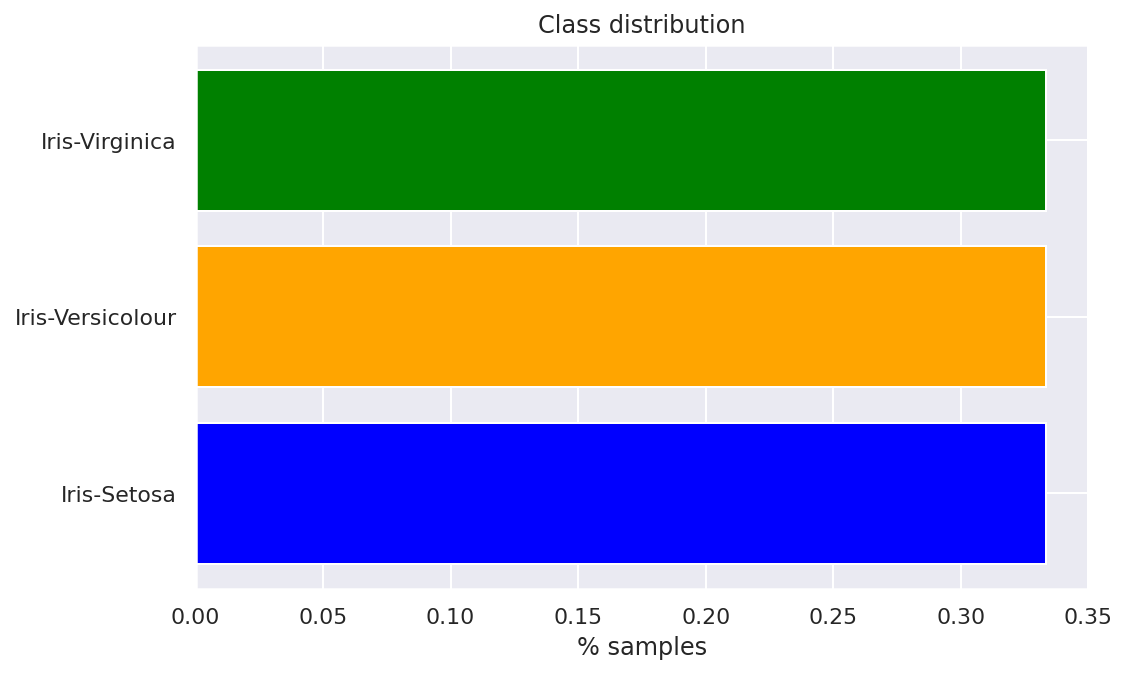

In [3]:
# Use only the first two features: sepal length and width

data = iris.data[:, :2]
targets = iris.target
print("Features shape: ", data.shape)

labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']
target_data = pd.Series(targets).map(labels)

plt_data = target_data.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
plt.barh(plt_data.index, plt_data.values, color=label_colours)
plt.xlabel("% samples")
plt.title("Class distribution")
plt.show()

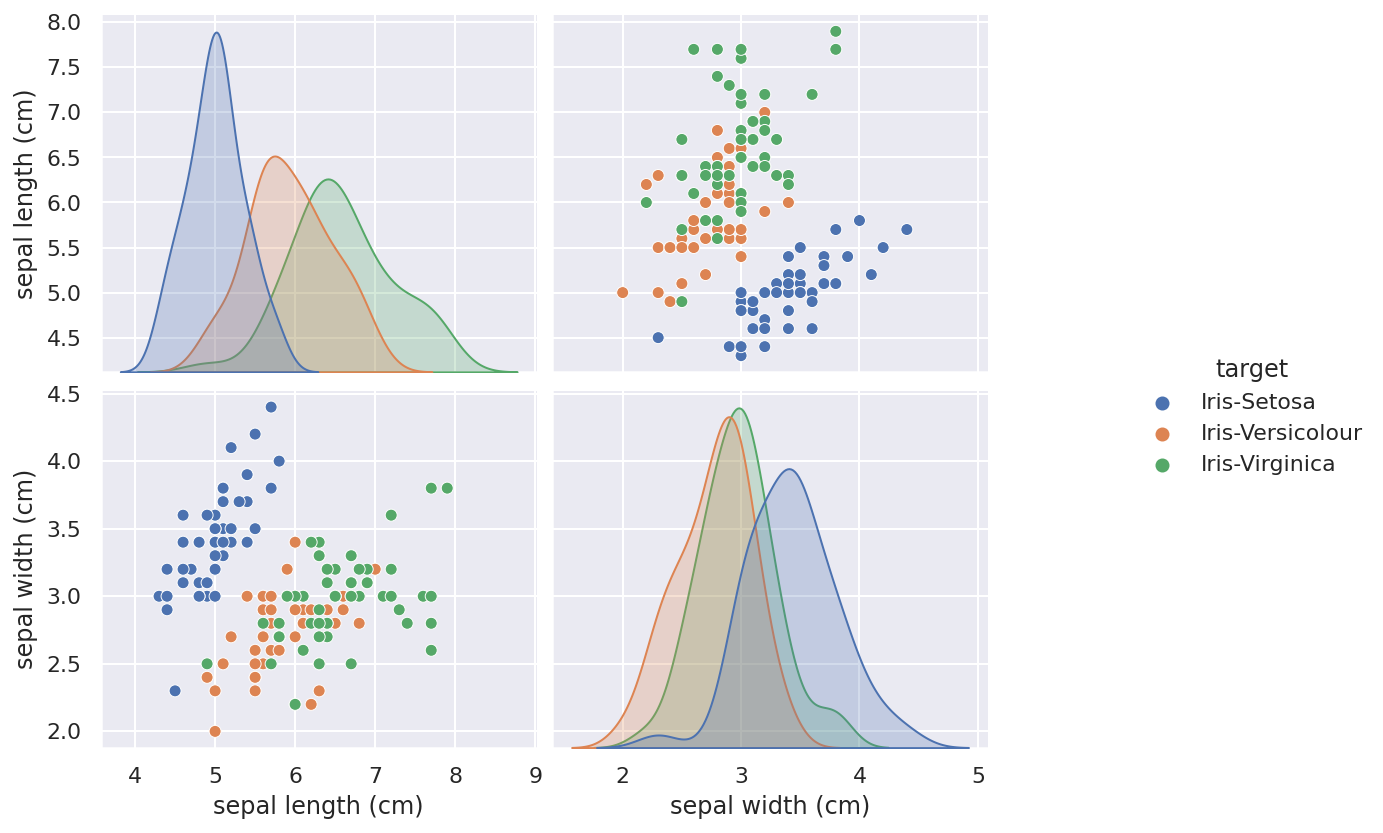

In [4]:
sns_df = pd.DataFrame(
    data=np.c_[data, target_data], 
    columns=iris.feature_names[:2] + ['target'])

sns.pairplot(sns_df, hue='target')\
    .fig.set_size_inches(10, 6)
plt.show()

In [5]:
# Randomly shuffle the data and make train and test splits

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data, targets, test_size=0.2)

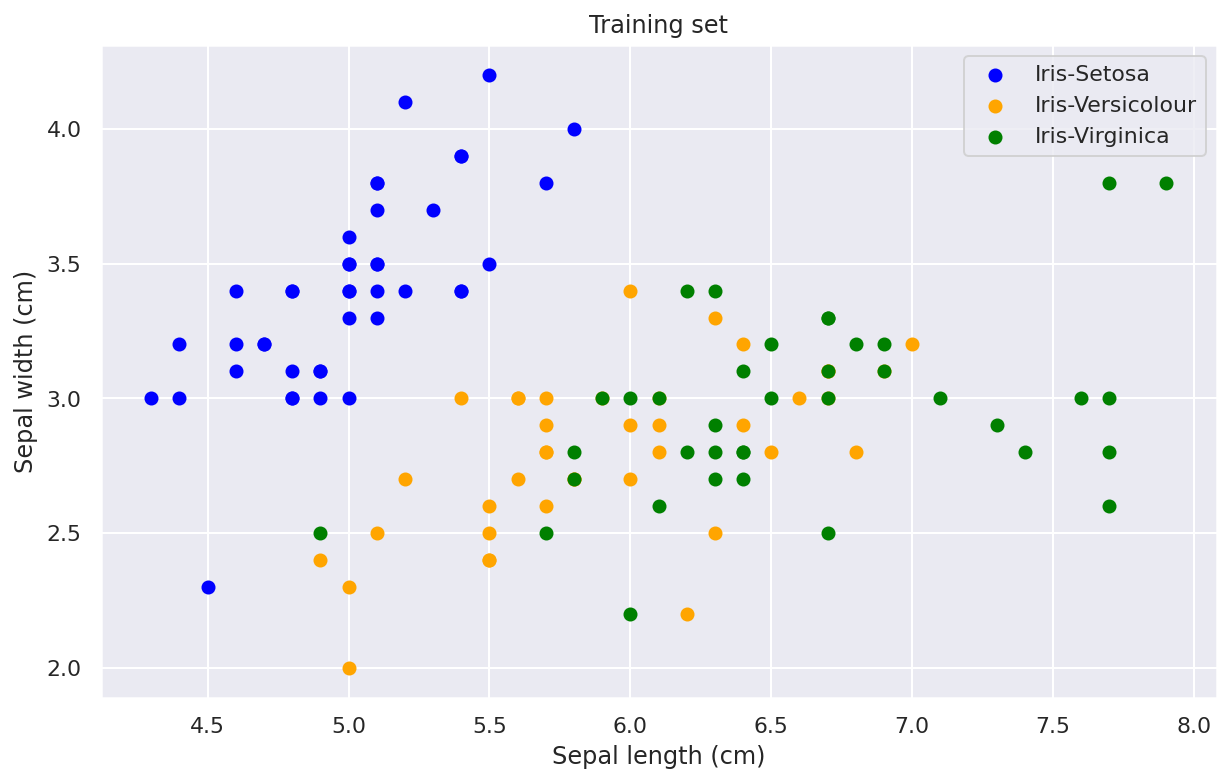

In [6]:
# Plot the training data

labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()
    
plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

### Naive Bayes classifier

We will briefly review the Naive Bayes classifier model. The fundamental equation for this classifier is Bayes' rule:

$$
P(Y=y_k | X_1,\ldots,X_d) = \frac{P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}
$$

In the above, $d$ is the number of features or dimensions in the inputs $X$ (in our case $d=2$), and $K$ is the number of classes (in our case $K=3$). The distribution $P(Y)$ is the class prior distribution, which is a discrete distribution over $K$ classes. The distribution $P(X | Y)$ is the class-conditional distribution over inputs.

The Naive Bayes classifier makes the assumption that the data features $X_i$ are conditionally independent give the class $Y$ (the 'naive' assumption). In this case, the class-conditional distribution decomposes as

$$
\begin{align}
P(X | Y=y_k) &= P(X_1,\ldots,X_d | Y=y_k)\\
&= \prod_{i=1}^d P(X_i | Y=y_k)
\end{align}
$$

This simplifying assumption means that we typically need to estimate far fewer parameters for each of the distributions $P(X_i | Y=y_k)$ instead of the full joint distribution $P(X | Y=y_k)$.

Once the class prior distribution and class-conditional densities are estimated, the Naive Bayes classifier model can then make a class prediction $\hat{Y}$ for a new data input $\tilde{X} := (\tilde{X}_1,\ldots,\tilde{X}_d)$ according to

$$
\begin{align}
\hat{Y} &= \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) \\
&= \text{argmax}_{y_k}\frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}\\
&= \text{argmax}_{y_k} P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)
\end{align}
$$

#### Define the class prior distribution
 
We will begin by defining the class prior distribution. To do this we will simply take the maximum likelihood estimate, given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

where the superscript $(n)$ indicates the $n$-th dataset example, $\delta(Y^{(n)}=y_k) = 1$ if $Y^{(n)}=y_k$ and 0 otherwise, and $N$ is the total number of examples in the dataset. The above is simply the proportion of data examples belonging to class $k$.

You should now write a function that builds the prior distribution from the training data, and returns it as a `Categorical` Distribution object.

* The input to your function `y` will be a numpy array of shape `(num_samples,)`
* The entries in `y` will be integer labels $k=0, 1,\ldots, K-1$
* Your function should build and return the prior distribution as a `Categorical` distribution object
  * The probabilities for this distribution will be a length-$K$ vector, with entries corresponding to $P(Y = y_k)$ for $k=0,1,\ldots,K-1$
  * Your function should work for any value of $K\ge 1$
  * This Distribution will have an empty batch shape and empty event shape

In [7]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_prior(y):
    """
    This function takes training labels as a numpy array y of 
    shape (num_samples,) as an input.
    This function should build a Categorical Distribution object with 
    empty batch shape and event shape, with the probability of each class 
    given as above. Your function should return the Distribution object.
    """
    
    classes = np.unique(y)
    n_classes = classes.shape[0]
    counts = np.zeros(n_classes, dtype=np.float32)
    for k in classes:
        counts[k] = np.sum(np.where(y==k, 1, 0))
    probs = counts / np.sum(counts)
    print(f"The class priors are {probs}")
    
    return tfd.Categorical(probs=probs)

In [8]:
# Run your function to get the prior

prior = get_prior(y_train)
prior

The class priors are [0.35       0.33333334 0.31666666]


<tfp.distributions.Categorical 'Categorical' batch_shape=[] event_shape=[] dtype=int32>

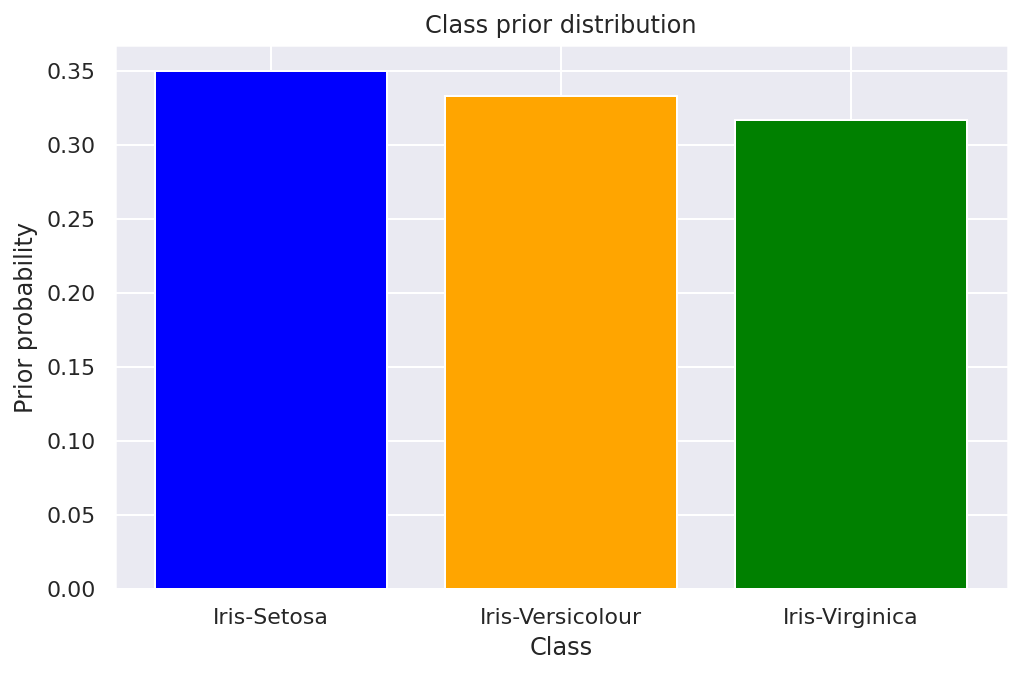

In [9]:
# Plot the prior distribution

labels = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
plt.figure(figsize=(8, 5))
plt.bar([0, 1, 2], prior.probs.numpy(), color=label_colours)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

#### Define the class-conditional densities

We now turn to the definition of the class-conditional distributions $P(X_i | Y=y_k)$ for $i=0, 1$ and $k=0, 1, 2$. In our model, we will assume these distributions to be univariate Gaussian:

$$
\begin{align}
P(X_i | Y=y_k) &= N(X_i | \mu_{ik}, \sigma_{ik})\\
&= \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x - \mu_{ik}}{\sigma_{ik}}\right)^2\right\}
\end{align}
$$
with mean parameters $\mu_{ik}$ and standard deviation parameters $\sigma_{ik}$, twelve parameters in all. We will again estimate these parameters using maximum likelihood. In this case, the estimates are given by

$$
\begin{align}
\hat{\mu}_{ik} &= \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
\hat{\sigma}^2_{ik} &= \frac{\sum_n (X_i^{(n)} - \hat{\mu}_{ik})^2 \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)}
\end{align}
$$

Note that the above are just the means and variances of the sample data points for each class.

You should now write a function to computes the class-conditional Gaussian densities, using the maximum likelihood parameter estimates given above, and returns them in a single, batched `MultivariateNormalDiag` Distribution object. 

* The inputs to the function are 
  * a numpy array `x` of shape `(num_samples, num_features)` for the data inputs
  * a numpy array `y` of shape `(num_samples,)` for the target labels
* Your function should work for any number of classes $K\ge 1$ and any number of features $d\ge 1$

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs.
    This function should build the class-conditional 
    Gaussian distributions above. It should construct a batch of 
    distributions for each feature and each class, using the 
    parameter estimates above for the means and standard deviations.
    The batch shape of this distribution should be rank 2, 
    where the first dimension corresponds to the number of classes and 
    the second corresponds to the number of features.
    Your function should then return the Distribution object.
    """
    
    classes = np.unique(y)
    n_classes = classes.shape[0]
    n_features = x.shape[-1]
    locs = np.zeros((n_classes, n_features), 
        dtype=np.float32)
    scales = np.zeros((n_classes, n_features), 
        dtype=np.float32)
    for k in classes:
        class_mask = (y==k)
        locs[k] = np.mean(x[class_mask, :], axis=0)
        scales[k] = np.std(x[class_mask, :], axis=0)

    return tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)

In [11]:
# Run your function to get the class-conditional distributions

class_conditionals = get_class_conditionals(x_train, y_train)
class_conditionals

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

We can visualise the class-conditional densities with contour plots by running the cell below. Notice how the contours of each distribution correspond to a Gaussian distribution with diagonal covariance matrix, since the model assumes that each feature is independent given the class.

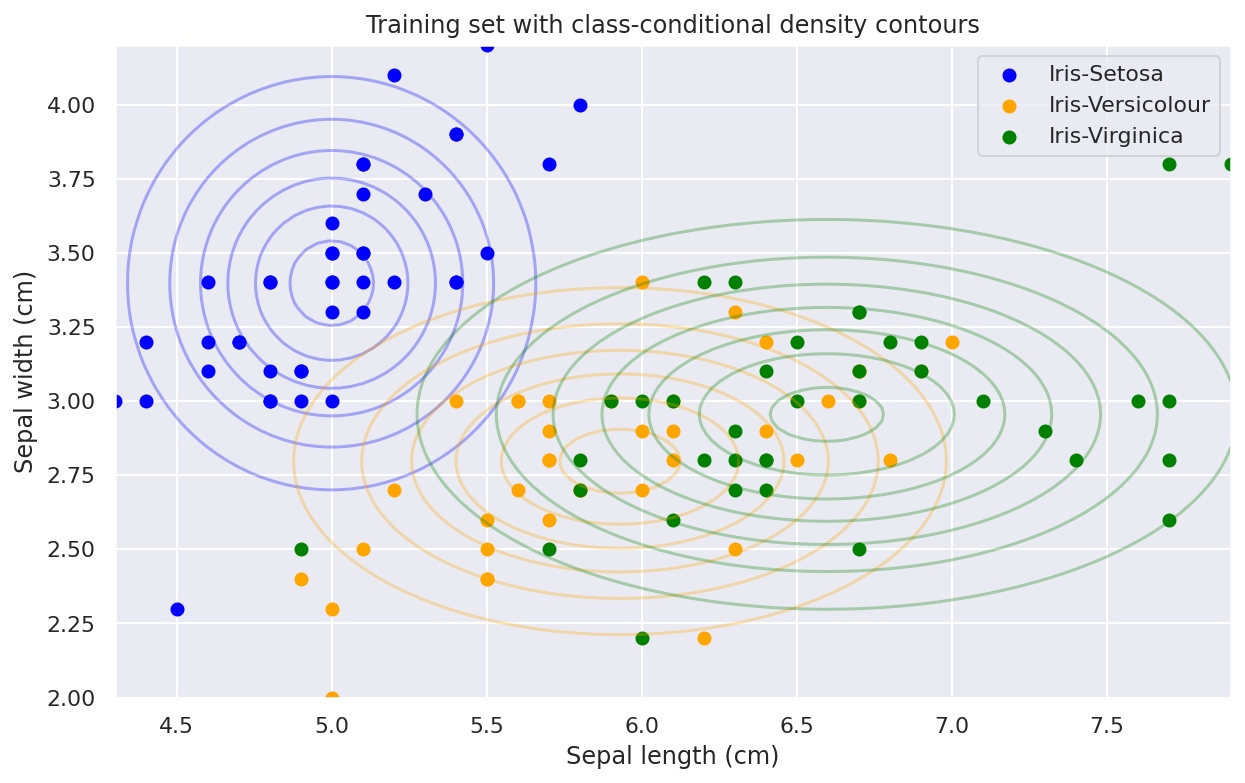

In [12]:
# Plot the training data with the class-conditional density contours

def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, prob_fn, batch_shape, colours, 
    levels=None, num_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = prob_fn(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1))
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, 
                colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], alpha=0.3,
                colors=colours[batch])

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
    class_conditionals.prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

#### Make predictions from the model

Now the prior and class-conditional distributions are defined, you can use them to compute the model's class probability predictions for an unknown test input $\tilde{X} = (\tilde{X}_1,\ldots,\tilde{X}_d)$, according to

$$
P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) = \frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}
$$

The class prediction can then be taken as the class with the maximum probability:

$$
\hat{Y} = \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d)
$$

You should now write a function to return the model's class probabilities for a given batch of test inputs of shape `(batch_shape, 2)`, where the `batch_shape` has rank at least one. 

* The inputs to the function are the `prior` and `class_conditionals` distributions, and the inputs `x`
* Your function should use these distributions to compute the probabilities for each class $k$ as above
  * As before, your function should work for any number of classes $K\ge 1$
* It should then compute the prediction by taking the class with the highest probability
* The predictions should be returned in a numpy array of shape `(batch_shape)`

In [13]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def predict_class(prior, class_conditionals, x):
    """
    This function takes the prior distribution, class-conditional distribution, 
    and a batch of inputs in a numpy array of shape (batch_shape, 2).
    This function should compute the class probabilities for each input in 
    the batch, using the prior and class-conditional distributions, 
    according to the above equation. Note that the batch_shape of x could have 
    rank higher than one! Your function should then return the class 
    predictions by taking the class with the maximum probability in a 
    numpy array of shape (batch_shape,).
    """
    
    cond_probs = class_conditionals.log_prob(
        np.expand_dims(x, axis=1))
    joint_likelihood = tf.add(
        tf.math.log(prior.probs), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(
        joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor
    
    return np.argmax(tf.exp(log_prob), axis=-1)

In [14]:
# Get the class predictions

predictions = predict_class(prior, 
    class_conditionals, x_test)
predictions

array([0, 0, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 2, 2, 0,
       1, 1, 2, 1, 1, 0, 1, 2])

In [15]:
# Evaluate the model accuracy on the test set

accuracy = accuracy_score(y_test, predictions)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8667


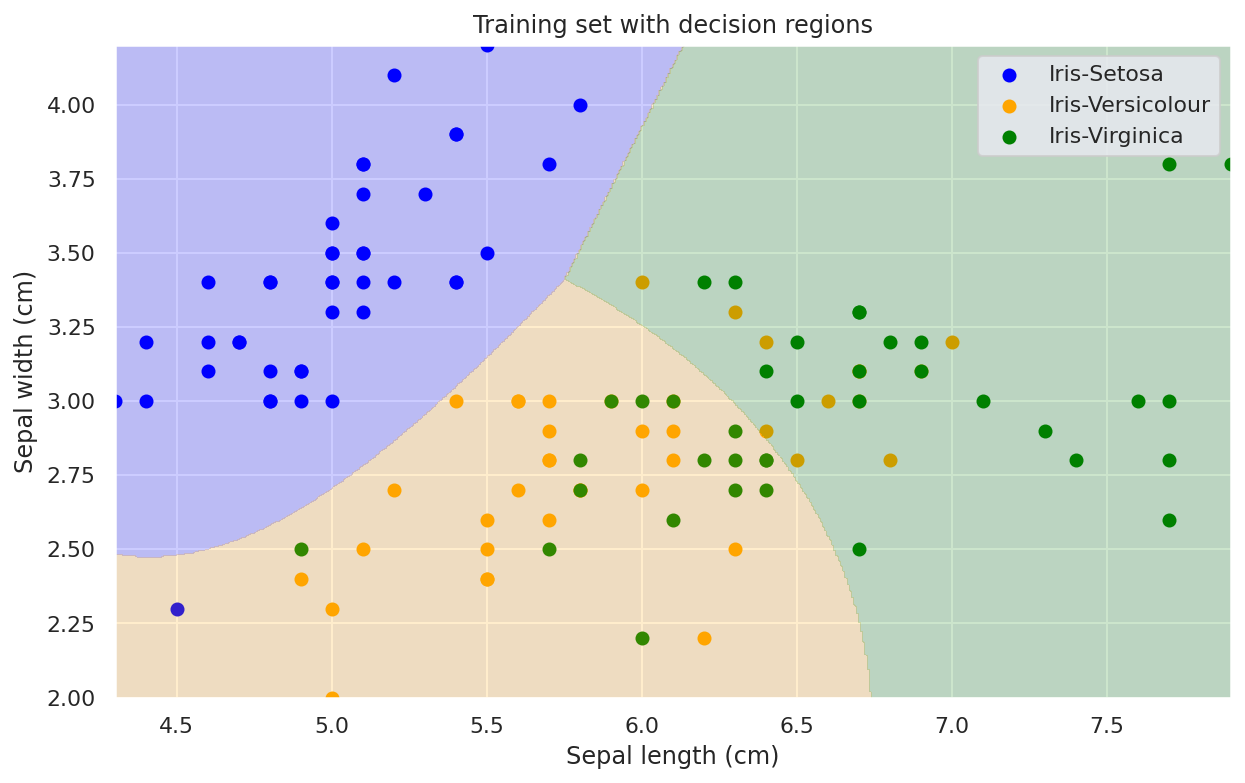

In [16]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
    lambda x: predict_class(prior, class_conditionals, x), 
    1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
    num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Binary classifier

We will now draw a connection between the Naive Bayes classifier and logistic regression.

First, we will update our model to be a binary classifier. In particular, the model will output the probability that a given input data sample belongs to the 'Iris-Setosa' class: $P(Y=y_0 | \tilde{X}_1,\ldots,\tilde{X}_d)$. The remaining two classes will be pooled together with the label $y_1$.

In [17]:
# Redefine the dataset to have binary labels

y_train_binary = np.array(y_train)
y_train_binary[np.where(y_train_binary == 2)] = 1

y_test_binary = np.array(y_test)
y_test_binary[np.where(y_test_binary == 2)] = 1

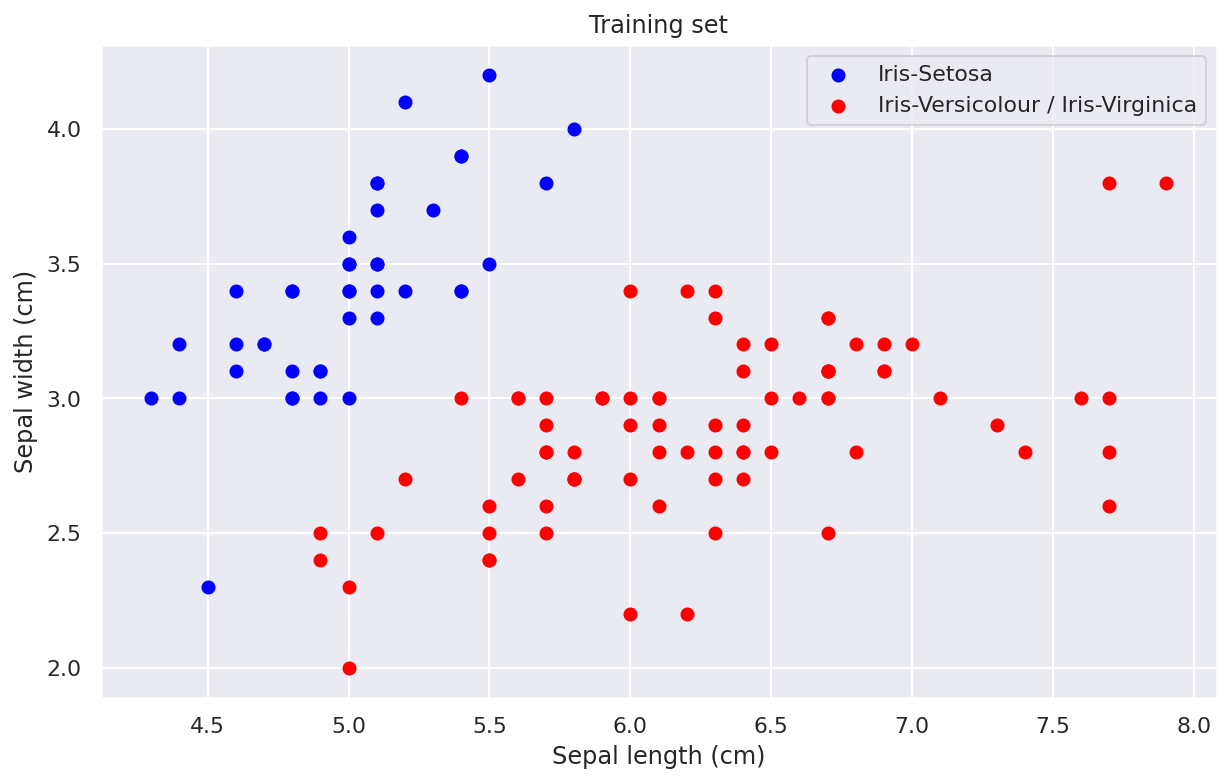

In [18]:
# Plot the training data

labels_binary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour / Iris-Virginica'}
label_colours_binary = ['blue', 'red']

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
plt.show()

We will also make an extra modelling assumption that for each class $k$, the class-conditional distribution $P(X_i | Y=y_k)$ for each feature $i=0, 1$, has standard deviation $\sigma_i$, which is the same for each class $k$. 

This means there are now six parameters in total: four for the means $\mu_{ik}$ and two for the standard deviations $\sigma_i$ ($i, k=0, 1$). 

We will again use maximum likelihood to estimate these parameters. The prior distribution will be as before, with the class prior probabilities given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

We will use your previous function `get_prior` to redefine the prior distribution.

In [19]:
# Redefine the prior

prior_binary = get_prior(y_train_binary)
prior_binary

The class priors are [0.35 0.65]


<tfp.distributions.Categorical 'Categorical' batch_shape=[] event_shape=[] dtype=int32>

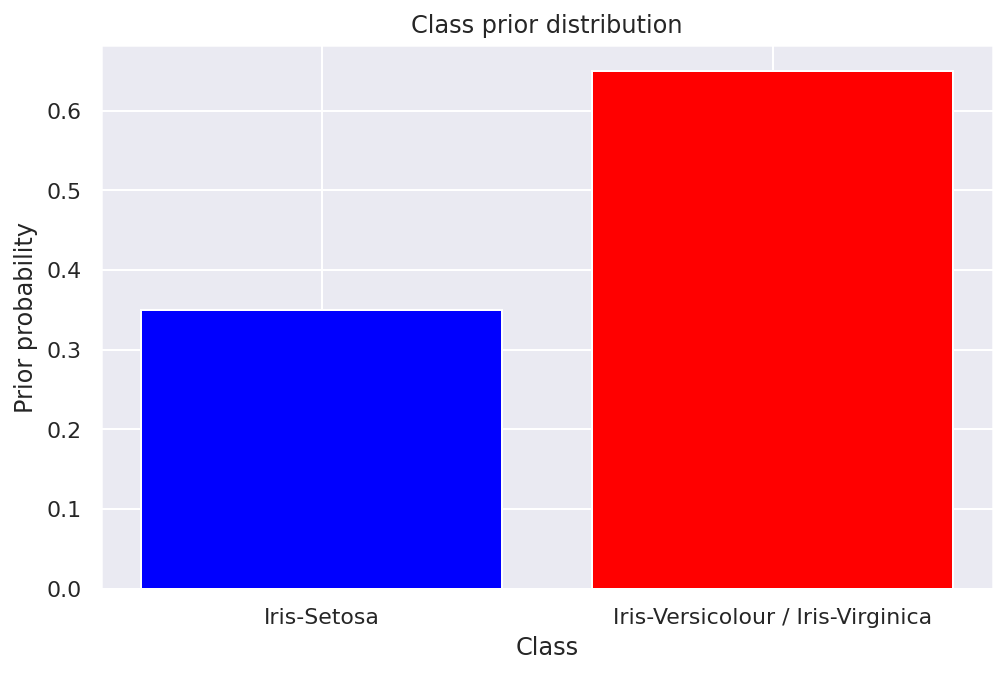

In [20]:
# Plot the prior distribution

plt.figure(figsize=(8, 5))
plt.bar([0, 1], prior_binary.probs.numpy(), color=label_colours_binary)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1], [v for v in labels_binary.values()])
plt.show()

For the class-conditional densities, the maximum likelihood estimate for the means are again given by

$$
\hat{\mu}_{ik} = \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
$$

However, the estimate for the standard deviations $\sigma_i$ is updated. There is also a closed-form solution for the shared standard deviations, but we will instead learn these from the data.

You should now write a function that takes the training inputs and target labels as input, as well as an optimizer object, number of epochs and a TensorFlow Variable. This function should be written according to the following spec:

* The inputs to the function are:
  * a numpy array `x` of shape `(num_samples, num_features)` for the data inputs
  * a numpy array `y` of shape `(num_samples,)` for the target labels
  * a `tf.Variable` object `scales` of length 2 for the standard deviations $\sigma_i$
  * `optimiser`: an optimiser object
  * `epochs`: the number of epochs to run the training for
* The function should first compute the means $\mu_{ik}$ of the class-conditional Gaussians according to the above equation
* Then create a batched multivariate Gaussian distribution object using `MultivariateNormalDiag` with the means set to $\mu_{ik}$ and the scales set to `scales`
* Run a custom training loop for `epochs` number of epochs, in which:
  * the average per-example negative log likelihood for the whole dataset is computed as the loss
  * the gradient of the loss with respect to the `scales` variables is computed
  * the `scales` variables are updated by the `optimiser` object
* At each iteration, save the values of the `scales` variable and the loss
* The function should return a tuple of three objects:
   * a numpy array of shape `(epochs,)` of loss values
   * a numpy array of shape `(epochs, 2)` of values for the `scales` variable at each iteration
   * the final learned batched `MultivariateNormalDiag` distribution object
   
_NB: ideally, we would like to constrain the `scales` variable to have positive values. We are not doing that here, but in later weeks of the course you will learn how this can be implemented._

In [22]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def learn_stdevs(x, y, scales, optimiser, epochs):
    """
    This function takes the data inputs, targets, scales variable, optimiser 
    and number of epochs as inputs.
    This function should set up and run a custom training loop according to the 
    above specifications, by setting up the class conditional distributions as 
    a MultivariateNormalDiag object, and updating the trainable variables 
    (the scales) in a custom training loop. Your function should then return 
    the a tuple of three elements: a numpy array of loss values during training, 
    a numpy array of scales variables during training, and the final learned
    MultivariateNormalDiag distribution object.
    """
    
    def nll(x_train, y_train, distribution, num_classes):
        x = tf.cast(tf.expand_dims(x_train, axis=1), 
            dtype=tf.float32)
        cond_probs = distribution.log_prob(x)
        y = tf.one_hot(indices=y_train, 
            depth=num_classes)
        log_probs = tf.math.reduce_sum(cond_probs*y, axis=1)

        return -tf.math.reduce_mean(log_probs)
    
    @tf.function
    def get_loss_and_grads(x_train, y_train, distribution, num_classes):
        with tf.GradientTape() as tape:
            tape.watch(distribution.trainable_variables)
            loss = nll(x_train, y_train, distribution, num_classes)
            grads = tape.gradient(loss, 
                distribution.trainable_variables)

        return loss, grads

    classes = np.unique(y)
    n_classes = classes.shape[0]
    n_features = x.shape[-1]
    locs = np.zeros((n_classes, n_features), 
        dtype=np.float32)
    for k in classes:
        class_mask = (y==k)
        locs[k, :] = np.mean(x[class_mask, :], axis=0)
      
    distribution = tfd.MultivariateNormalDiag(
        loc=locs, scale_diag=scales)

    train_losses = []
    train_scales = []

    for epoch in range(epochs):
        loss, grads = get_loss_and_grads(
            x, y, distribution, n_classes)
        optimiser.apply_gradients(zip(grads, 
            distribution.trainable_variables))
        
        scale_value = distribution.stddev().numpy()[0]
        train_losses.append(loss)
        train_scales.append(scale_value)

        if (epoch%50==0):
            print(f"Iteration: {epoch:03d}: Loss: {loss:.4f}: "\
                f"Scale: [{scale_value[0]:.4f}, {scale_value[1]:.4f}]")

    return (np.array(train_losses), np.array(train_scales), distribution)

In [23]:
# Define the inputs to your function

scales = tf.Variable([1., 1.])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
epochs = 300

In [24]:
# Run your function to learn the class-conditional standard deviations

nlls, scales_arr, class_conditionals_binary = learn_stdevs(
    x_train, y_train_binary, scales, opt, epochs)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Iteration: 000: Loss: 2.0711: Scale: [0.9900, 0.9900]
Iteration: 050: Loss: 1.3332: Scale: [0.5749, 0.4715]
Iteration: 100: Loss: 1.2332: Scale: [0.5929, 0.3463]
Iteration: 150: Loss: 1.2326: Scale: [0.5930, 0.3386]
Iteration: 200: Loss: 1.2326: Scale: [0.5931, 0.3386]
Iteration: 250: Loss: 1.2326: Scale: [0.5931, 0.3386]


In [25]:
# View the distribution parameters

print("Class conditional means:")
print(class_conditionals_binary.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals_binary.stddev().numpy())

Class conditional means:
[[5.        3.397619 ]
 [6.2551284 2.874359 ]]

Class conditional standard deviations:
[[0.5931058  0.33860564]
 [0.5931058  0.33860564]]


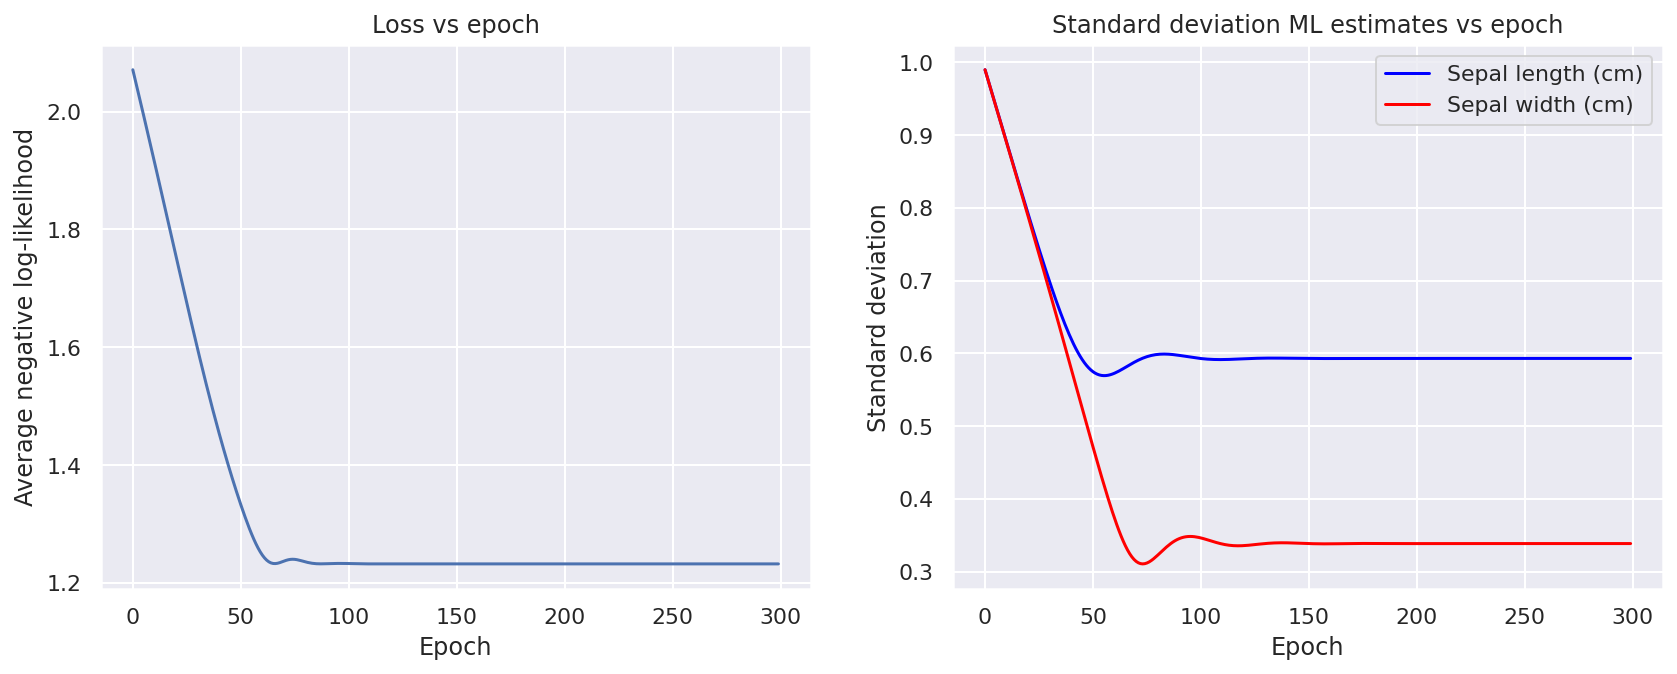

In [26]:
# Plot the loss and convergence of the standard deviation parameters

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(nlls)
ax[0].set_title("Loss vs epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Average negative log-likelihood")

features_label = {0: 'Sepal length (cm)', 1: 'Sepal width (cm)'} 
features_colour = ['blue', 'red'] 
for k in [0, 1]:
    ax[1].plot(scales_arr[:, k], color=features_colour[k], 
        label=features_label[k])
ax[1].set_title("Standard deviation ML estimates vs epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Standard deviation")
plt.legend()
plt.show()

We can also plot the contours of the class-conditional Gaussian distributions as before, this time with just binary labelled data. Notice the contours are the same for each class, just with a different centre location.

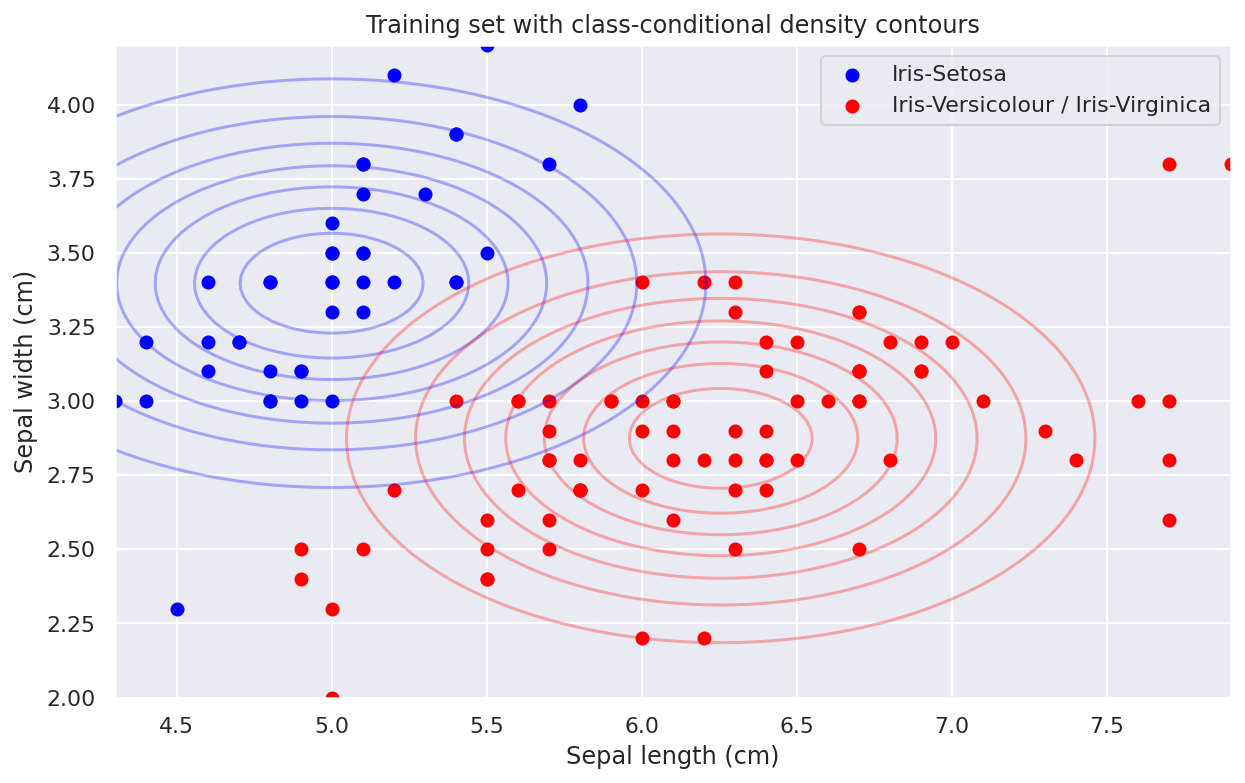

In [27]:
# Plot the training data with the class-conditional density contours

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, 
    label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
    class_conditionals_binary.prob, 2, label_colours_binary)
plt.title("Training set with class-conditional density contours")
plt.show()

We can also plot the decision regions for this binary classifier model, notice that the decision boundary is now linear.

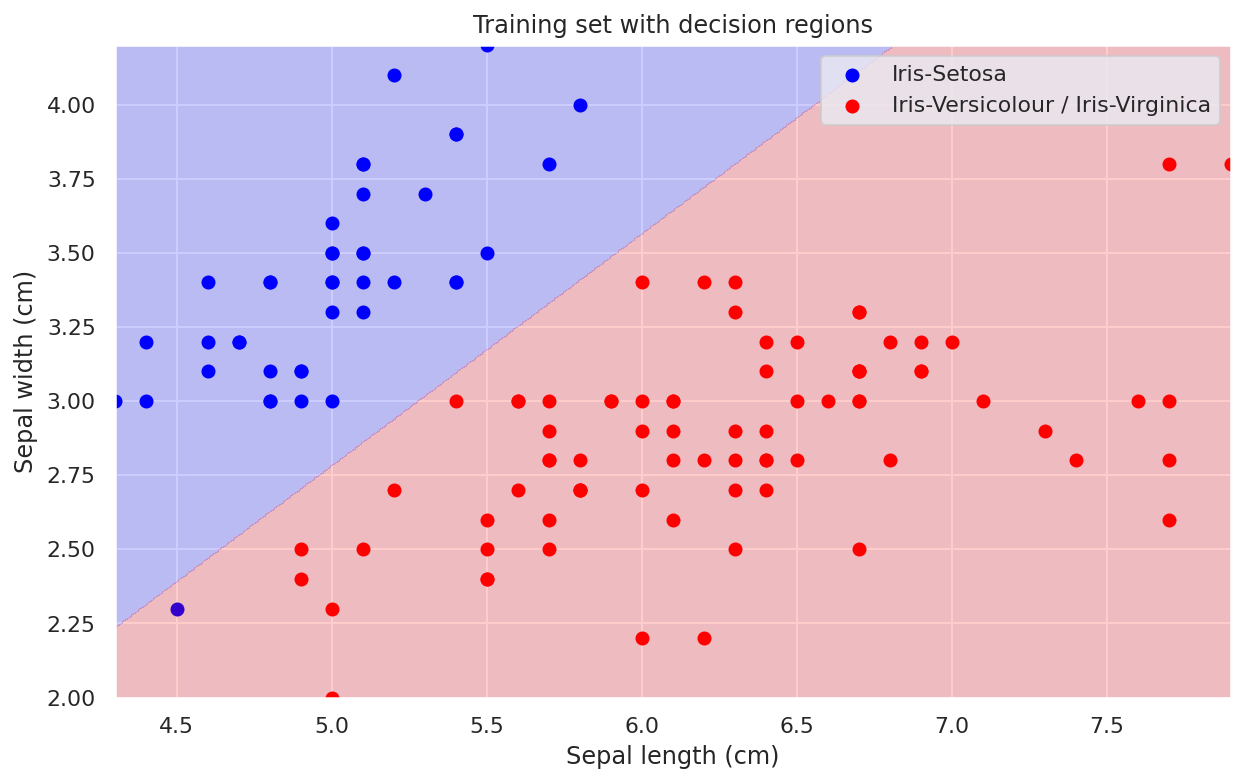

In [28]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, 
    label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
    lambda x: predict_class(prior_binary, class_conditionals_binary, x), 
        1, label_colours_binary, levels=[-0.5, 0.5, 1.5], num_points=500)
plt.title("Training set with decision regions")
plt.show()

#### Link to logistic regression

In fact, we can see that our predictive distribution $P(Y=y_0 | X)$ can be written as follows:


$$
\begin{align}
P(Y=y_0 | X) =& ~\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_0)P(Y=y_0) + P(X | Y=y_1)P(Y=y_1)}\\
=&  ~\frac{1}{1 + \frac{P(X | Y=y_1)P(Y=y_1)}{P(X | Y=y_0)P(Y=y_0)}}\\
=& ~\sigma(a)
\end{align}
$$

where $\sigma(a) = \frac{1}{1 + e^{-a}}$ is the sigmoid function, and $a = \log\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_1)P(Y=y_1)}$ is the _log-odds_.

With our additional modelling assumption of a shared covariance matrix $\Sigma$, it can be shown (using the Gaussian pdf) that $a$ is in fact a linear function of $X$: 

$$
a = w^T X + w_0
$$

where

$$
\begin{align}
w =& ~\Sigma^{-1} (\mu_0 - \mu_1)\\
w_0 =& -\frac{1}{2}\mu_0^T \Sigma^{-1}\mu_0 + \frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 + \log\frac{P(Y=y_0)}{P(Y=y_1)}
\end{align}
$$

The model therefore takes the form $P(Y=y_0 | X) = \sigma(w^T X + w_0)$, with weights $w\in\mathbb{R}^2$ and bias $w_0\in\mathbb{R}$. This is the form used by logistic regression, and explains why the decision boundary above is linear. 

In the above we have outlined the derivation of the generative logistic regression model. The parameters are typically estimated with maximum likelihood, as we have done. 

Finally, we will use the above equations to directly parameterise the output Bernoulli distribution of the generative logistic regression model.

You should now write the following function, according to the following specification:

* The inputs to the function are:
  * the prior distribution `prior` over the two classes
  * the (batched) class-conditional distribution `class_conditionals`
* The function should use the parameters of the above distributions to compute the weights and bias terms $w$ and $w_0$ as above
* The function should then return a tuple of two numpy arrays for $w$ and $w_0$

In [29]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.
@tf.function
def get_logistic_regression_params(prior, class_conditionals):
    """
    This function takes the prior distribution and class-conditional 
    distribution as inputs. This function should compute the weights 
    and bias terms of the generative logistic regression model 
    as above, and return them in a 2-tuple of numpy arrays of shapes
    (2,) and () respectively.
    """
    
    sigma = class_conditionals_binary.covariance()[0]
    inv_sigma = tf.linalg.inv(sigma)
    mu0 = tf.expand_dims(class_conditionals_binary.mean()[0],
        axis=-1)
    mu1 = tf.expand_dims(class_conditionals_binary.mean()[1],
        axis=-1)
    inv_sigma_mu0 = tf.linalg.matmul(inv_sigma, mu0)
    inv_sigma_mu1 = tf.linalg.matmul(inv_sigma, mu1)
    w = tf.squeeze(inv_sigma_mu0 - inv_sigma_mu1)
    w0 = tf.squeeze(-0.5*tf.linalg.matmul(tf.transpose(mu0), inv_sigma_mu0)
        + 0.5*tf.linalg.matmul(tf.transpose(mu1), inv_sigma_mu1)
        + tf.math.log(prior_binary.probs[0]/prior_binary.probs[1]))

    return (w, w0)

In [30]:
# Run your function to get the logistic regression parameters

w, w0 = get_logistic_regression_params(prior_binary, 
    class_conditionals_binary)

We can now use these parameters to make a contour plot to display the predictive distribution of our logistic regression model.

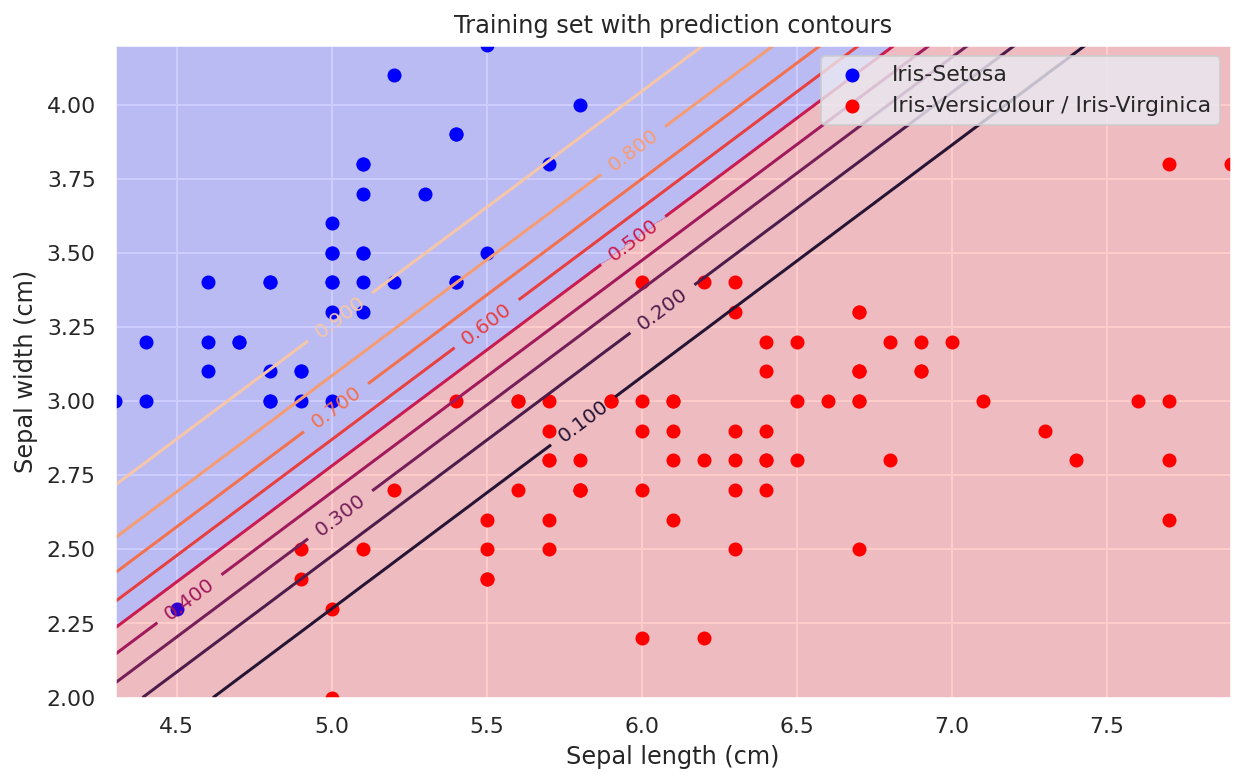

In [31]:
# Plot the training data with the logistic regression prediction contours

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
X0, X1 = get_meshgrid((x0_min, x0_max), (x1_min, x1_max))

logits = np.dot(np.array([X0.ravel(), X1.ravel()]).T, w) + w0
Z = tf.math.sigmoid(logits)
lr_contour = ax.contour(X0, X1, np.array(Z).T.reshape(*X0.shape), levels=10)
ax.clabel(lr_contour, inline=True, fontsize=10)
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
    lambda x: predict_class(prior_binary, class_conditionals_binary, x), 
    1, label_colours_binary, levels=[-0.5, 0.5, 1.5], num_points=300)
plt.title("Training set with prediction contours")
plt.show()

Congratulations on completing this programming assignment! In the next week of the course we will look at Bayesian neural networks and uncertainty quantification.